In [1]:
import os
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf

In [3]:
parent_dir = '/var/www/feature_vector_400_samples'
file_name = 'feature_vectors_400_samples.txt'
embeddings = np.loadtxt(os.path.join(parent_dir, file_name))

In [4]:
embeddings.shape

(400, 4096)

In [32]:

def pairwise_squared_distances(embeddings):
    # shape (batch_size, batch_size)
    dot_product = tf.matmul(embeddings, tf.transpose(embeddings))

    # Get squared L2 norm for each embedding. We can just take the diagonal of `dot_product`.
    # This also provides more numerical stability (the diagonal of the result will be exactly 0).
    # shape (batch_size,)
    square_norm = tf.linalg.diag_part(dot_product)

    # Compute the pairwise distance matrix as we have:
    # ||a - b||^2 = ||a||^2  - 2 <a, b> + ||b||^2
    # shape (batch_size, batch_size)
    distances = tf.expand_dims(square_norm, 0) - 2.0 * dot_product + tf.expand_dims(square_norm, 1)

    # Because of computation errors, some distances might be negative so we put everything >= 0.0
    distances = tf.maximum(distances, 0.0)

    return distances


In [33]:
pair_dists = pairwise_squared_distances(embeddings)

In [34]:
pair_dists

<tf.Tensor: id=139, shape=(400, 400), dtype=float64, numpy=
array([[    0.        ,  4832.20838969,  5812.61078839, ...,
         8876.48569303,  8057.56287978,  9812.07630406],
       [ 4832.20838969,     0.        ,  5513.6338298 , ...,
         9778.35118959,  8900.33076392, 10845.14606962],
       [ 5812.61078839,  5513.6338298 ,     0.        , ...,
         9882.05652667,  9080.48372067, 10575.79527483],
       ...,
       [ 8876.48569303,  9778.35118959,  9882.05652667, ...,
            0.        ,  3862.22671627,  7342.81368563],
       [ 8057.56287978,  8900.33076392,  9080.48372067, ...,
         3862.22671627,     0.        ,  7733.17465619],
       [ 9812.07630406, 10845.14606962, 10575.79527483, ...,
         7342.81368563,  7733.17465619,     0.        ]])>

In [ ]:
def batch_all_triplet_loss(labels, embeddings, margin):
    # Get the pairwise distance matrix
    pairwise_dist = _pairwise_squared_distances(embeddings)
    anchor_positive_dist = tf.expand_dims(pairwise_dist, 2)
    anchor_negative_dist = tf.expand_dims(pairwise_dist, 1)

In [37]:
anchor_positive_dist = tf.expand_dims(pair_dists, 2)
anchor_negative_dist = tf.expand_dims(pair_dists, 1)

In [39]:
anchor_negative_dist

<tf.Tensor: id=144, shape=(400, 1, 400), dtype=float64, numpy=
array([[[    0.        ,  4832.20838969,  5812.61078839, ...,
          8876.48569303,  8057.56287978,  9812.07630406]],

       [[ 4832.20838969,     0.        ,  5513.6338298 , ...,
          9778.35118959,  8900.33076392, 10845.14606962]],

       [[ 5812.61078839,  5513.6338298 ,     0.        , ...,
          9882.05652667,  9080.48372067, 10575.79527483]],

       ...,

       [[ 8876.48569303,  9778.35118959,  9882.05652667, ...,
             0.        ,  3862.22671627,  7342.81368563]],

       [[ 8057.56287978,  8900.33076392,  9080.48372067, ...,
          3862.22671627,     0.        ,  7733.17465619]],

       [[ 9812.07630406, 10845.14606962, 10575.79527483, ...,
          7342.81368563,  7733.17465619,     0.        ]]])>

In [6]:
def load_images(directory):
    xs = []
    for filename in os.listdir(directory):
        im = Image.open(os.path.join(directory, filename), 'r')
        X = np.array(im.crop((0,0,96,96)).getdata()).reshape(27648,)
        xs.append(X)
    Xtr = np.array(xs)
    del X
    return Xtr

In [7]:
def get_k_similar_images(test_image_path, images, k=1, norm=1):
    test_im = Image.open(test_image_path, 'r')
    Xtest = np.array(test_im.crop((0,0,96,96)).getdata()).reshape(27648,)
    if norm not in [1,2]:
        raise Exception("Only 1 or 2 numbers are accepted.")
    dists = np.linalg.norm(images-Xtest, ord=norm, axis=1)
    ids = np.argsort(dists)[:k]
    return ids

In [8]:
def plot_similar_images(ids, images):
    N = (len(ids)+1)//2 
    figure, axes = plt.subplots(N, 2)
    i=0
    for n in range(N):
        for m in range(2):
            if n==N-1 and m==1:
                break
            axes[n,m].imshow(images[ids[i]].reshape(96, 96, 3))
            i+=1 
    if len(ids)%2!=0:
        figure.delaxes(axes[n,m])
    else:
        axes[n,m].imshow(images[ids[i]].reshape(96, 96, 3))


[ 956 1836  515  361  684]


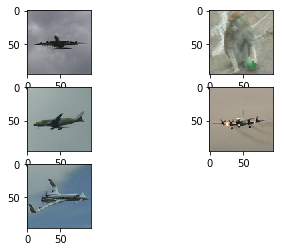

In [9]:
images_dir = 'data/train'
test_image_path = 'data/test/test.png'

images = load_images(images_dir)
ids = get_k_similar_images(test_image_path, images, k=5, norm=2)
print(ids)
plot_similar_images(ids, images)